<div id="container" style="position:relative;">
<div style="float:left"><h1> Predicting NHL Goal Scoring - Feature Engineering </h1></div>
<br>
    <br>
    <br>

***BrainStation Data Science Capstone Project*** <br/>
***Author:***  &ensp;    **Taylor Gallivan** <br/>
***Date:*** &ensp; **Sep-Nov 2023** 

## Introduction

Feature Engineering has been an iterative process on this project.  After preliminary Feature Engineering was completed, a baseline linear regression model was ran on the data; before running the model, independent variables were tested for collinearity, and P-values were calculated for each of the independent variables to test for statistical significance relative to the target feature.  There were two main takeaways from the results of that preliminary analysis:
    1. Several of the engineered features were found to be highly collinear, having Pearson r-values greater than 0.7.  This was not surpising - the features were engineered versions of variables already contained in the dataset.  However, what was surpising was that, in some cases, the engineered features were less strongly correlated with the target feature than the variable(s) from which they were calculated.  In general, the intent of engineered features is to reduce the feature space by capturing the predictive power of multiple variables within a single engineered one.  The results of the preliminary analysis suggest that the mark was missed in some cases.
    2. One of the steps originally taken in this notebook was to one-hot encode the contents of the `franchise` variable into 32 individual features - one for each of the 32 franchises currently in the league.  After calculating P-values for each of the features passed into the baseline linear regression model, 30 of the 32 franchise features had calculated P-values that exceeded the rule-of-thumb threshold of 0.05, with the majority of the features having values greater than 0.5.  This indicated that simply knowing what team a player was playing for during a given season was statistically insignificant to predicting the target feature (for all but two franchises).  The hope with including a player's team in the dataset was that the model would be able to make connections between the quality of a player's teammates and an increased likelihood of goal production.  Either such connections are insignificant (unlikely) or a standard linear regression model is not sophisticated enough to make these connections.  I would be interested to run the full dataset through a neural network or other deep learning model, where I suspect that the sophistication of the model would be able to derive *some* predictive value from the franchise features
    
The R2 score of the original model was found to be quite low, which caused me to reevaluate some of the prioritizations made when setting up this project; in particular, the inherent trade-off between data quantity and quality. The raw dataset that I was able to collect contained ~38,000 entries, making this a relatively small dataset in the context of training Machine Learning models.  As such, I was reluctant to drop any data that was expected to contain predictive value within my dataset.  This was distilled into two main considerations:
- which player positions to keep?
- what sample size of games played (in a season) is significant?

The initial answer to these questions was to keep all player positions (other then goaltenders, which were filtered out during data collection), and to only exclude seasons where a player appeared in less than 8 games, which is ~10% of the full 82-game season. 

The R2 values on both the train and test datasets of my baseline Linear Regression model were quite similar - suggesting that model overfitting was not an issue.  With model overfitting being one of the main concerns with a small dataset, the similar R2 values for train and test data gave me the confidence to reprioritize the aforementioned considerations in the following way:
- remove the 'defenseman' player position from the dataset:  over the last 3 full NHL seasons, defensemen contributed only 2,643 of the 18,809 goals scored in total by all positions, or at a rate of just over 14%.  With defensemen scoring such a low proportion of the total goals scored, they entries represent low quality data compared to their forward counterparts.  The three forward positions (Left Wing, Center, Right Wing) are the positions that teams rely on for goal scoring, and the positions I care most about predicting goal totals for.  
- increase the cutoff threshold of `games_played` from 10% (8 games) to 20% (17 games):  the lower the number of games that a player played in a given season, the more susceptible the results will be to bias, and the higher the likelihood that 'noise' is contributed to the dataset. 



### Table of Contents 
1. [Drop Data](#part1)
2. [Feature Engineering](#part2)
3. [Target Feature & Unique Identifier](#part3)
4. [Encoding Categorical Columns](#part4)

In [44]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_5.csv')

# sort values, to be sure
df = df.sort_values(by=['player_id', 'season_start_yr'])

# reset index, to be sure
df.reset_index(drop=True, inplace=True)

# sanity check
df.shape

(24503, 29)

In [46]:
df.head()

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,12.0,0.0,5.0,0.0,65.0,36,688.693839,9.0,21.0,6.0,0.0,-14.0,9,43.351520,10.212643,524.456686,431.340444,61.218289,31.898058,0
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,35.0,2.0,10.0,0.0,202.0,78,1492.169986,42.0,77.0,21.0,0.0,-7.0,30,93.928293,22.127393,1136.322819,934.570962,132.639625,69.112458,0
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,20.0,1.0,6.0,0.0,140.0,72,1377.387679,27.0,47.0,16.0,0.0,-16.0,19,86.703040,20.425286,1048.913372,862.680888,122.436577,63.796115,0
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,36.0,3.0,12.0,0.0,227.0,80,1530.430754,40.0,76.0,28.0,0.0,-24.0,30,96.336711,22.694762,1165.459302,958.534320,136.040641,70.884572,0
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,19.0,2.0,9.0,0.0,144.0,61,1166.953450,14.0,33.0,14.0,0.0,-21.0,24,73.456742,17.304756,888.662718,730.882419,103.730989,54.049486,0


In [47]:
# review full column list and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24503 entries, 0 to 24502
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            24503 non-null  int64  
 1   name                 24503 non-null  object 
 2   height               24503 non-null  int64  
 3   weight               24503 non-null  int64  
 4   position_name        24503 non-null  object 
 5   position_type        24503 non-null  object 
 6   season_start_yr      24503 non-null  int64  
 7   player_age           24503 non-null  int64  
 8   franchise            24503 non-null  object 
 9   goals                24503 non-null  float64
 10  game_winning_goals   24503 non-null  float64
 11  power_play_goals     24503 non-null  float64
 12  short_handed_goals   24503 non-null  float64
 13  shots                24503 non-null  float64
 14  games_played         24503 non-null  int64  
 15  shifts               24503 non-null 

## Drop Data <a class="anchor" id="part1" ></a>
Based on the premise of prioritizing data quality over quantity, the following data needs to be pruned from the DataFrame:
- all entries where `position_name` is 'defenseman'
- all entries where `games_played` is less than 17

Starting with the 'defenseman' entries:

In [48]:
# check value counts by position name
df.groupby(['position_name'])['position_name'].count()

position_name
Center        6369
Defenseman    8484
Left Wing     4829
Right Wing    4821
Name: position_name, dtype: int64

In [49]:
# check value counts by position type
df.groupby(['position_type'])['position_type'].count()

position_type
Defenseman     8484
Forward       16019
Name: position_type, dtype: int64

In [50]:
# filter only the entries where 'position_type' is 'forward',
# reassign filted Dataframe to itself
df = df[df['position_type']=='Forward']

# sanity check
df.shape

(16019, 29)

Now increase cutoff values for `games_played`:

In [51]:
# filter only the entries where 'games_played' is greater than or equal to 17
# reassign filtered DataFrame to itself
df = df[df['games_played']>=17]

# sanity check
df.shape

(15244, 29)

In [52]:
# resort DataFrame, to be sure
df = df.sort_values(by=['player_id', 'season_start_yr'])

# reset index
df.reset_index(drop=True, inplace=True)

Based on findings from running the baseline linear regression model, there are several features that can be dropped from the dataset for having either high collinearity with other independent features, or high P-values suggesting low statistical significance as a predict of the target feature.  

The following columns can be dropped:
- `position_type`
- `points`
- `power_play_points`
- `short_handed_points`
- `plus_minus`

In [53]:
# execute column drop
df = df.drop(columns=['position_type', 'position_name', 'power_play_points', \
                      'points', 'short_handed_points', 'total_toi'])
df.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'franchise', 'goals', 'game_winning_goals',
       'power_play_goals', 'short_handed_goals', 'shots', 'games_played',
       'shifts', 'assists', 'plus_minus', 'penalty_minutes', 'hits', 'blocked',
       'even_strength_toi', 'power_play_toi', 'short_handed_toi',
       'midseason_trades'],
      dtype='object')

## Feature Engineering <a class="anchor" id="part2" ></a>

### Create Season Number Feature
The intent with this feature is to provide the model with context for how long a player has been in the league, which might not be tied to age.  For players that are late bloomers, they may have a delayed career trajectory that would place their *prime* offensive years later into their career.  We can capture this detail by instantiating a feature called `season_num` which keeps a running total of how many seasons a player has appeared in prior to the `season_start_yr` of a given entry.

In [54]:
# initialize new feature 'season_num'
df['season_num'] = 0  # initialize all values as 0

In [55]:
# enumerate through DataFrame to populate 'season_num' feature
for ind, player in enumerate(df['player_id']):
    if ind==0:  # catch condition to prevent loop from erroring upon initiation
        df.loc[ind, 'season_num'] = 1
    else:
        last_player = df.loc[ind-1, 'player_id']
        if player==last_player:  # compare if the current and last player in the df are the same
            # if players are the same, assign 'season_num' from last entry and add one
            df.loc[ind, 'season_num'] = df.loc[ind-1, 'season_num'] + 1  
        else:
            # if the players are different, then this is a new player - pass initial value of 1
            df.loc[ind, 'season_num'] = 1


In [56]:
df.head(20)

,player_id,name,height,weight,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades,season_num
0,8444894,Greg Adams,76,196,1984,21,NJD,12.0,0.0,5.0,0.0,65.0,36,688.693839,9.0,-14.0,9,43.351520,10.212643,431.340444,61.218289,31.898058,0,1
1,8444894,Greg Adams,76,196,1985,22,NJD,35.0,2.0,10.0,0.0,202.0,78,1492.169986,42.0,-7.0,30,93.928293,22.127393,934.570962,132.639625,69.112458,0,2
2,8444894,Greg Adams,76,196,1986,23,NJD,20.0,1.0,6.0,0.0,140.0,72,1377.387679,27.0,-16.0,19,86.703040,20.425286,862.680888,122.436577,63.796115,0,3
3,8444894,Greg Adams,76,196,1987,24,VAN,36.0,3.0,12.0,0.0,227.0,80,1530.430754,40.0,-24.0,30,96.336711,22.694762,958.534320,136.040641,70.884572,0,4
4,8444894,Greg Adams,76,196,1988,25,VAN,19.0,2.0,9.0,0.0,144.0,61,1166.953450,14.0,-21.0,24,73.456742,17.304756,730.882419,103.730989,54.049486,0,5
5,8444894,Greg Adams,76,196,1989,26,VAN,30.0,1.0,13.0,0.0,181.0,65,1243.474988,20.0,-8.0,18,78.273578,18.439494,778.809135,110.533021,57.593715,0,6
6,8444894,Greg Adams,76,196,1990,27,VAN,21.0,2.0,5.0,1.0,148.0,55,1052.171144,24.0,-5.0,10,66.231489,15.602649,658.992345,93.527941,48.733144,0,7
7,8444894,Greg Adams,76,196,1991,28,VAN,30.0,5.0,13.0,1.0,184.0,76,1453.909217,27.0,8.0,26,91.519876,21.560024,910.607604,129.238609,67.340344,0,8
8,8444894,Greg Adams,76,196,1992,29,VAN,25.0,3.0,6.0,1.0,124.0,53,1013.910375,31.0,31.0,14,63.823071,15.035280,635.028987,90.126925,46.961029,0,9
9,8444894,Greg Adams,76,196,1993,30,VAN,13.0,2.0,5.0,1.0,139.0,68,1300.866141,24.0,-1.0,20,81.886204,19.290547,814.754172,115.634545,60.251887,0,10


### Create Offseason Trade Feature
There already exists a `midseason_trades` feature in the dataset, I want to instantiate a second feature that indicates if a player changed teams in the offseason.  To do so, enumerate through the DataFrame and encode a value of 1 wherever the `franchise` a player played in during season 'n' differs from the franchise that they played for in year 'n-1'.  A new features called `offseason_trade` will be instantiated to hold these binary encondings.  

In [57]:
# instantiate new feature 'offseason_trade'
df['offseason_trade'] = 0  # initialize all values as 0

In [58]:
# enumerate through DataFrame to populate 'offseason_trade' feature

# catch condition to prevent erroring when loop reaches final index position
end = df.shape[0]-1
range = np.arange(0, end)

for ind in range:
    current_team = df.loc[ind, 'franchise']
    next_team = df.loc[ind+1, 'franchise']
    current_player = df.loc[ind, 'player_id']
    next_player = df.loc[ind+1, 'player_id']
    if (current_team!=next_team) & (current_player==next_player):
        df.loc[ind+1, 'offseason_trade'] = 1
    else:
        pass

In [59]:
df

,player_id,name,height,weight,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades,season_num,offseason_trade
0,8444894,Greg Adams,76,196,1984,21,NJD,12.0,0.0,5.0,0.0,65.0,36,688.693839,9.0,-14.0,9,43.351520,10.212643,431.340444,61.218289,31.898058,0,1,0
1,8444894,Greg Adams,76,196,1985,22,NJD,35.0,2.0,10.0,0.0,202.0,78,1492.169986,42.0,-7.0,30,93.928293,22.127393,934.570962,132.639625,69.112458,0,2,0
2,8444894,Greg Adams,76,196,1986,23,NJD,20.0,1.0,6.0,0.0,140.0,72,1377.387679,27.0,-16.0,19,86.703040,20.425286,862.680888,122.436577,63.796115,0,3,0
3,8444894,Greg Adams,76,196,1987,24,VAN,36.0,3.0,12.0,0.0,227.0,80,1530.430754,40.0,-24.0,30,96.336711,22.694762,958.534320,136.040641,70.884572,0,4,1
4,8444894,Greg Adams,76,196,1988,25,VAN,19.0,2.0,9.0,0.0,144.0,61,1166.953450,14.0,-21.0,24,73.456742,17.304756,730.882419,103.730989,54.049486,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15239,8482109,Alexis Lafrenière,73,194,2021,19,NYR,19.0,4.0,0.0,0.0,110.0,79,1377.000000,12.0,2.0,37,108.000000,26.000000,1008.570000,93.430000,3.300000,0,2,0
15240,8482109,Alexis Lafrenière,73,194,2022,20,NYR,16.0,2.0,3.0,0.0,135.0,81,1405.000000,23.0,10.0,33,141.000000,28.000000,1118.770000,111.380000,2.630000,0,3,0
15241,8482116,Tim Stützle,72,197,2020,18,OTT,12.0,2.0,4.0,0.0,111.0,53,1012.000000,17.0,-18.0,14,50.000000,15.000000,682.100000,152.100000,0.000000,0,1,0
15242,8482116,Tim Stützle,72,197,2021,19,OTT,22.0,4.0,7.0,1.0,176.0,79,1678.000000,36.0,-27.0,37,125.000000,52.000000,1188.050000,256.050000,10.400000,0,2,0


### Set Up Reference Features
The target feature is a player's goal output from their 'n+1' season; set up another for loop to copy the contents of a player's values of `goals` and `games_played` from their 'n+1' season to their 'n' season.  The actual target feature will later be pro-rated to a full 82-season pace, which is why `games_played` will be set up as a reference feature as well.

In [60]:
# instantiate new features
df['goals_ref'] = 0  # initialize all values as 0
df['games_played_ref'] = 0

In [61]:
# enumerate through DataFrame to populate new features

# catch condition to prevent erroring when loop reaches final index position
end = df.shape[0]-1
range = np.arange(0, end)

for ind in range:
    current_player = df.loc[ind, 'player_id']
    next_player = df.loc[ind+1, 'player_id']
    next_goals = df.loc[ind+1, 'goals']
    next_games_played = df.loc[ind+1, 'games_played']
    if current_player==next_player:  # checking if the players being compared are the same
        # if the players are the same, we want the second player's values of 'goals' and 'games_played' for reference
        df.loc[ind, 'goals_ref'] = next_goals  
        df.loc[ind, 'games_played_ref'] = next_games_played
    else:
        pass

In [62]:
# check the result
df.loc[10:20, ['player_id', 'name', 'games_played', 'goals', 'games_played_ref', 'goals_ref']]

,player_id,name,games_played,goals,games_played_ref,goals_ref
10,8444894,Greg Adams,43,8.0,66,22
11,8444894,Greg Adams,66,22.0,50,21
12,8444894,Greg Adams,50,21.0,49,14
13,8444894,Greg Adams,49,14.0,75,19
14,8444894,Greg Adams,75,19.0,69,19
15,8444894,Greg Adams,69,19.0,60,11
16,8444894,Greg Adams,60,11.0,0,0
17,8444897,Keith Acton,61,15.0,78,36
18,8444897,Keith Acton,78,36.0,78,24
19,8444897,Keith Acton,78,24.0,71,20


### Recreate Shooting Percentage Feature

The stat `shot_pct` was dropped from the original dataset because, as a percentage, it would not have responded well to some of the preprocessing steps that involved groupby aggregations - for instance, the step where rows were aggreagted to flatten the `sequence_number` feature.

Now, that we have per season totals for all statistical categories, we can recalculate it but dividing number of goals scored in a season, by number of shots taken each season, for each player/entry in the DataFrame.  This is an engineered feature, as it attempts to distill the predictive value of the `goals` and `shots` features into a single, more powerful predictor of player goal scoring.

In [63]:
# instantiate 'shot_pct' and populate with calculated values
df['shot_pct'] = df['goals'] / df['shots']

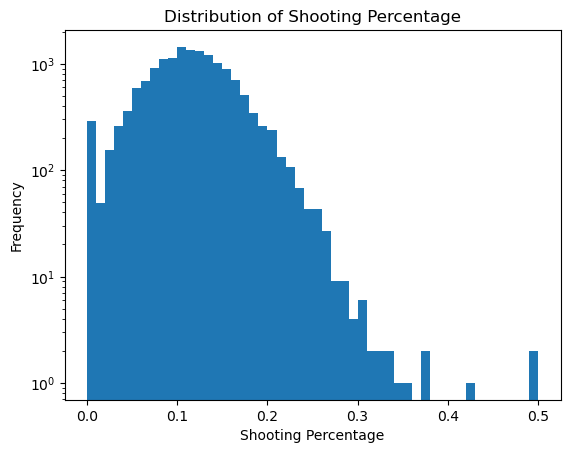

In [64]:
# Check the distribution
plt.figure()
plt.hist(df['shot_pct'], bins=50)

# Set the titles and labels
plt.title('Distribution of Shooting Percentage')
plt.xlabel('Shooting Percentage')
plt.ylabel('Frequency')
plt.yscale('log')

plt.show()

Check the first and last few entries in the DataFrame to make sure `shot_pct` was correctly implemented.

In [65]:
df.loc[10:20, ['player_id', 'name', 'shots', 'goals', 'shot_pct']]

,player_id,name,shots,goals,shot_pct
10,8444894,Greg Adams,72.0,8.0,0.111111
11,8444894,Greg Adams,140.0,22.0,0.157143
12,8444894,Greg Adams,113.0,21.0,0.185841
13,8444894,Greg Adams,75.0,14.0,0.186667
14,8444894,Greg Adams,176.0,19.0,0.107955
15,8444894,Greg Adams,129.0,19.0,0.147287
16,8444894,Greg Adams,66.0,11.0,0.166667
17,8444897,Keith Acton,101.0,15.0,0.148515
18,8444897,Keith Acton,218.0,36.0,0.165138
19,8444897,Keith Acton,154.0,24.0,0.155844


### Add in Per Season Averages
A separate dataset was downloaded directly from the web that contains season averages statistics for the entire league.  The dataset was preprocessed in excel for ease of merging it with the main DataFrame.  The particlar statistic of interest is `league_goal/game` which contains the average number of goals that single team scored per game, in each season (i.e., total goals scored in a season divided by the number of teams in the league that season, divided by the number of games in the season).  It is hoped that this stat will provide context to the model about an inividual player's goal scoring in a season, relative to the average scoring rate across the entire league.

Import `league_goal/game` into the DataFrame:

In [66]:
# Load the data 
avg_stats_df = pd.read_csv('season_avgs.csv')

# Don't need one of the columns
avg_stats_df.drop(columns=['league_ppg/game'], inplace=True)

# Display data
avg_stats_df

,season_start_yr,league_goal/game
0,2022,3.18
1,2021,3.14
2,2020,2.94
3,2019,3.02
4,2018,3.01
5,2017,2.97
6,2016,2.77
7,2015,2.71
8,2014,2.73
9,2013,2.74


In [67]:
# df.info()

In [68]:
# join the two DataFrames on shared column 'season_start_yr'
df = df.merge(avg_stats_df, how='left', on='season_start_yr')
df.shape

(15244, 29)

In [69]:
df.tail(15)[['player_id', 'name', 'games_played', 'league_goal/game']]

,player_id,name,games_played,league_goal/game
15229,8481554,Kaapo Kakko,82,3.18
15230,8481559,Jack Hughes,61,3.02
15231,8481559,Jack Hughes,56,2.94
15232,8481559,Jack Hughes,49,3.14
15233,8481559,Jack Hughes,78,3.18
15234,8481624,Ilya Mikheyev,39,3.02
15235,8481624,Ilya Mikheyev,54,2.94
15236,8481624,Ilya Mikheyev,53,3.14
15237,8481624,Ilya Mikheyev,46,3.18
15238,8482109,Alexis Lafrenière,56,2.94


### Prorate Gameplay Stats
The gameplay stats should be prorated to a full season pace (82 games) - divide each gamplay stat by the value of `games_played` and then multiply by 82.  

This will be easier if all of the gameplay statistics are collected on one side of the DataFrame so first reorganize df.

In [70]:
# column list
df.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'franchise', 'goals', 'game_winning_goals',
       'power_play_goals', 'short_handed_goals', 'shots', 'games_played',
       'shifts', 'assists', 'plus_minus', 'penalty_minutes', 'hits', 'blocked',
       'even_strength_toi', 'power_play_toi', 'short_handed_toi',
       'midseason_trades', 'season_num', 'offseason_trade', 'goals_ref',
       'games_played_ref', 'shot_pct', 'league_goal/game'],
      dtype='object')

The number of gameplay statistics is more than the non-gameplay statistics - pass the non-gameplay statistics into a reference list:

In [71]:
# these columns to front of DataFrame
reference_list = ['player_id', 'name', 'height', 'weight', 'season_start_yr', \
                  'player_age', 'season_num', 'franchise', 'midseason_trades', 'offseason_trade', \
                  'shot_pct', 'league_goal/game', 'goals_ref', \
                  'games_played_ref', 'games_played']

# assign columns to temporary DataFrames
if all(item in df.columns for item in reference_list):
    player_stats = df[reference_list]
    gameplay_stats = df.drop(columns=reference_list)
else:
    # error condition to help with debugging
    print("Some columns in reference_list are not in the DataFrame")  

# sanity check
print(player_stats.shape)
print(gameplay_stats.shape)

(15244, 15)
(15244, 14)


In [72]:
# reform main DF
df = player_stats.join(gameplay_stats)
df

,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi
0,8444894,Greg Adams,76,196,1984,21,1,NJD,0,0,0.184615,3.89,35,78,36,12.0,0.0,5.0,0.0,65.0,688.693839,9.0,-14.0,9,43.351520,10.212643,431.340444,61.218289,31.898058
1,8444894,Greg Adams,76,196,1985,22,2,NJD,0,0,0.173267,3.97,20,72,78,35.0,2.0,10.0,0.0,202.0,1492.169986,42.0,-7.0,30,93.928293,22.127393,934.570962,132.639625,69.112458
2,8444894,Greg Adams,76,196,1986,23,3,NJD,0,0,0.142857,3.67,36,80,72,20.0,1.0,6.0,0.0,140.0,1377.387679,27.0,-16.0,19,86.703040,20.425286,862.680888,122.436577,63.796115
3,8444894,Greg Adams,76,196,1987,24,4,VAN,0,1,0.158590,3.71,19,61,80,36.0,3.0,12.0,0.0,227.0,1530.430754,40.0,-24.0,30,96.336711,22.694762,958.534320,136.040641,70.884572
4,8444894,Greg Adams,76,196,1988,25,5,VAN,0,0,0.131944,3.74,30,65,61,19.0,2.0,9.0,0.0,144.0,1166.953450,14.0,-21.0,24,73.456742,17.304756,730.882419,103.730989,54.049486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15239,8482109,Alexis Lafrenière,73,194,2021,19,2,NYR,0,0,0.172727,3.14,16,81,79,19.0,4.0,0.0,0.0,110.0,1377.000000,12.0,2.0,37,108.000000,26.000000,1008.570000,93.430000,3.300000
15240,8482109,Alexis Lafrenière,73,194,2022,20,3,NYR,0,0,0.118519,3.18,0,0,81,16.0,2.0,3.0,0.0,135.0,1405.000000,23.0,10.0,33,141.000000,28.000000,1118.770000,111.380000,2.630000
15241,8482116,Tim Stützle,72,197,2020,18,1,OTT,0,0,0.108108,2.94,22,79,53,12.0,2.0,4.0,0.0,111.0,1012.000000,17.0,-18.0,14,50.000000,15.000000,682.100000,152.100000,0.000000
15242,8482116,Tim Stützle,72,197,2021,19,2,OTT,0,0,0.125000,3.14,39,78,79,22.0,4.0,7.0,1.0,176.0,1678.000000,36.0,-27.0,37,125.000000,52.000000,1188.050000,256.050000,10.400000


In [73]:
# check column order
df.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'season_num', 'franchise', 'midseason_trades',
       'offseason_trade', 'shot_pct', 'league_goal/game', 'goals_ref',
       'games_played_ref', 'games_played', 'goals', 'game_winning_goals',
       'power_play_goals', 'short_handed_goals', 'shots', 'shifts', 'assists',
       'plus_minus', 'penalty_minutes', 'hits', 'blocked', 'even_strength_toi',
       'power_play_toi', 'short_handed_toi'],
      dtype='object')

Columns in correct order, indexes unchanged.

Next plot the distributions of each of the gameplay statistics for before-after comparison

In [74]:
# select the gameplay stats columns
game_stats = df.iloc[:, -14:]

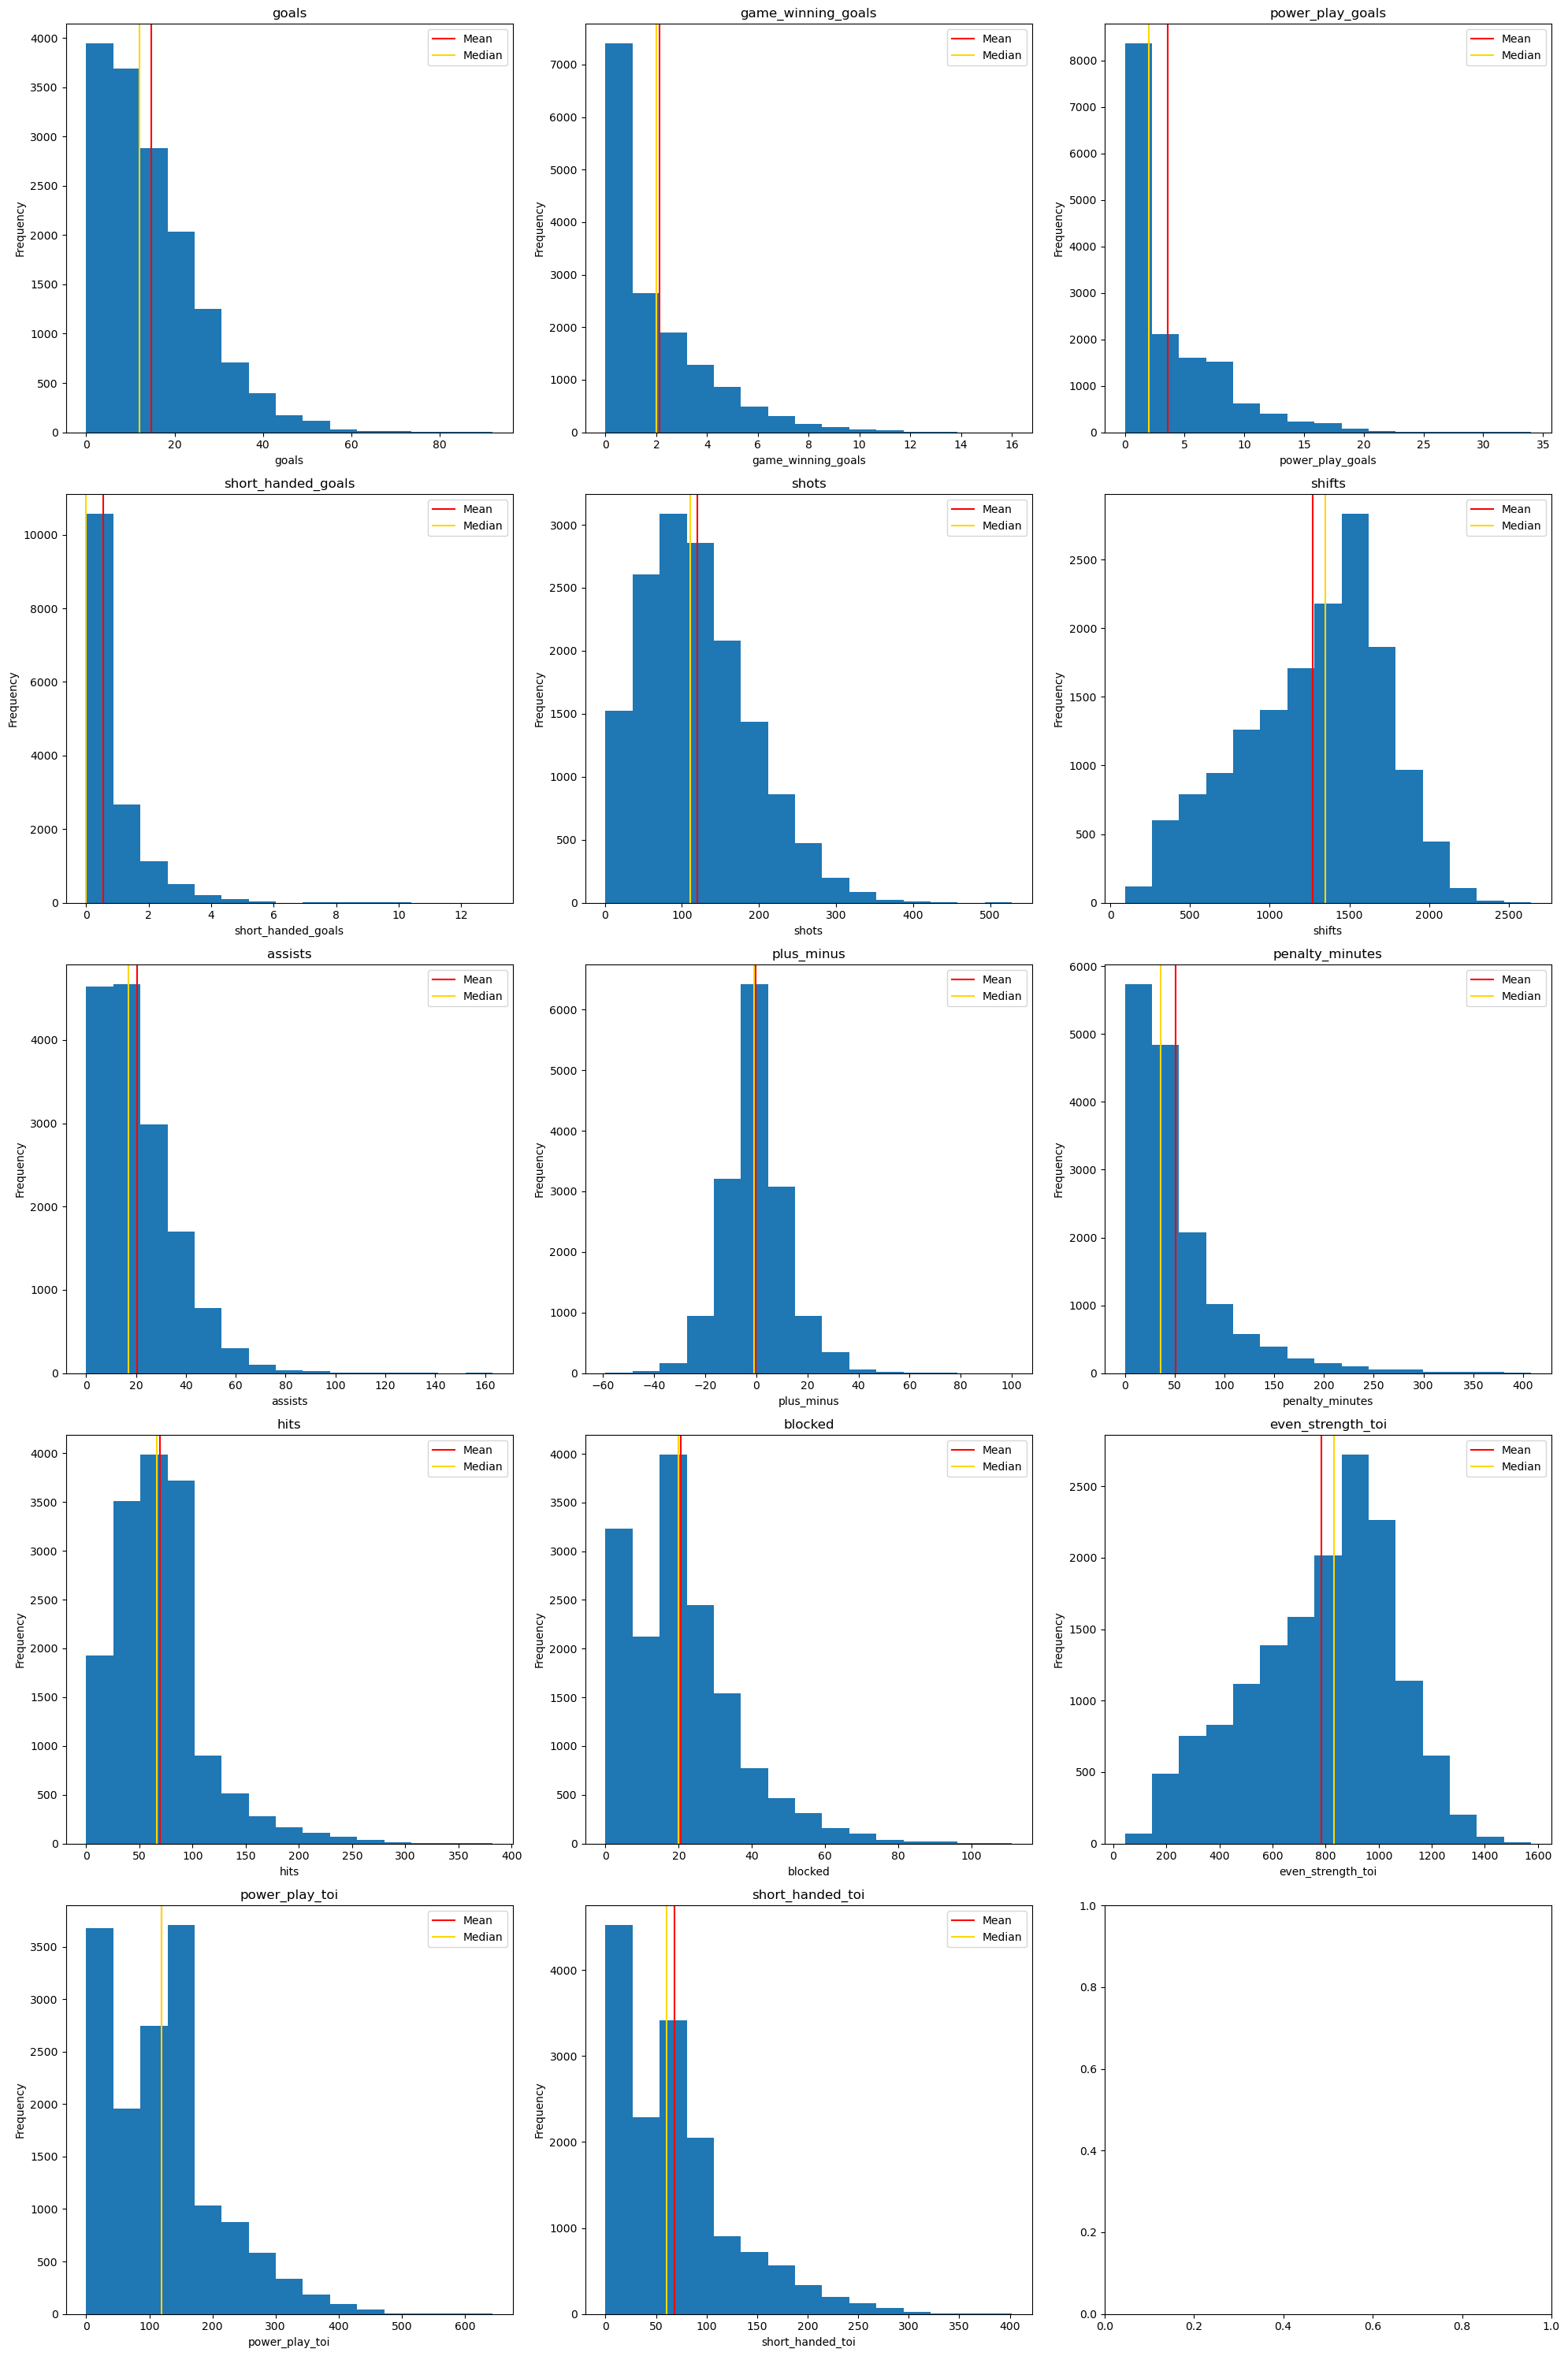

In [75]:
# plot distributions for comparison after computation

# plot will have 5 rows, 3 subplots per row
plt.subplots(5, 3, figsize=(20,30))

# Creating the for loop
for slot_num, each_column in enumerate(game_stats.columns, start=1):
    
    # Creating a hist for every iteration
    plt.subplot(5,3,slot_num)
    plt.hist(game_stats[each_column], bins=15)
    
    # Set the titles and labels
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    
    # Adding median and mean lines
    plt.axvline(game_stats[each_column].mean(), c='red', label='Mean')
    plt.axvline(game_stats[each_column].median(), c='gold', label='Median')
    plt.legend()
    
plt.tight_layout()

plt.show()

Prorate values the gameplay stats:

In [76]:
# first multiple each stat by 82 so they will be prorated for a full season
game_stats = game_stats * 82

# divide each gameplay stat by number of games_played
# axis=0 specifies to divide along the rows
df.iloc[:, -14:] = game_stats.div(df['games_played'], axis=0)

Replot the distributions

In [77]:
# reselect the gameplay stats columns
game_stats_avg = df.iloc[:, -14:]

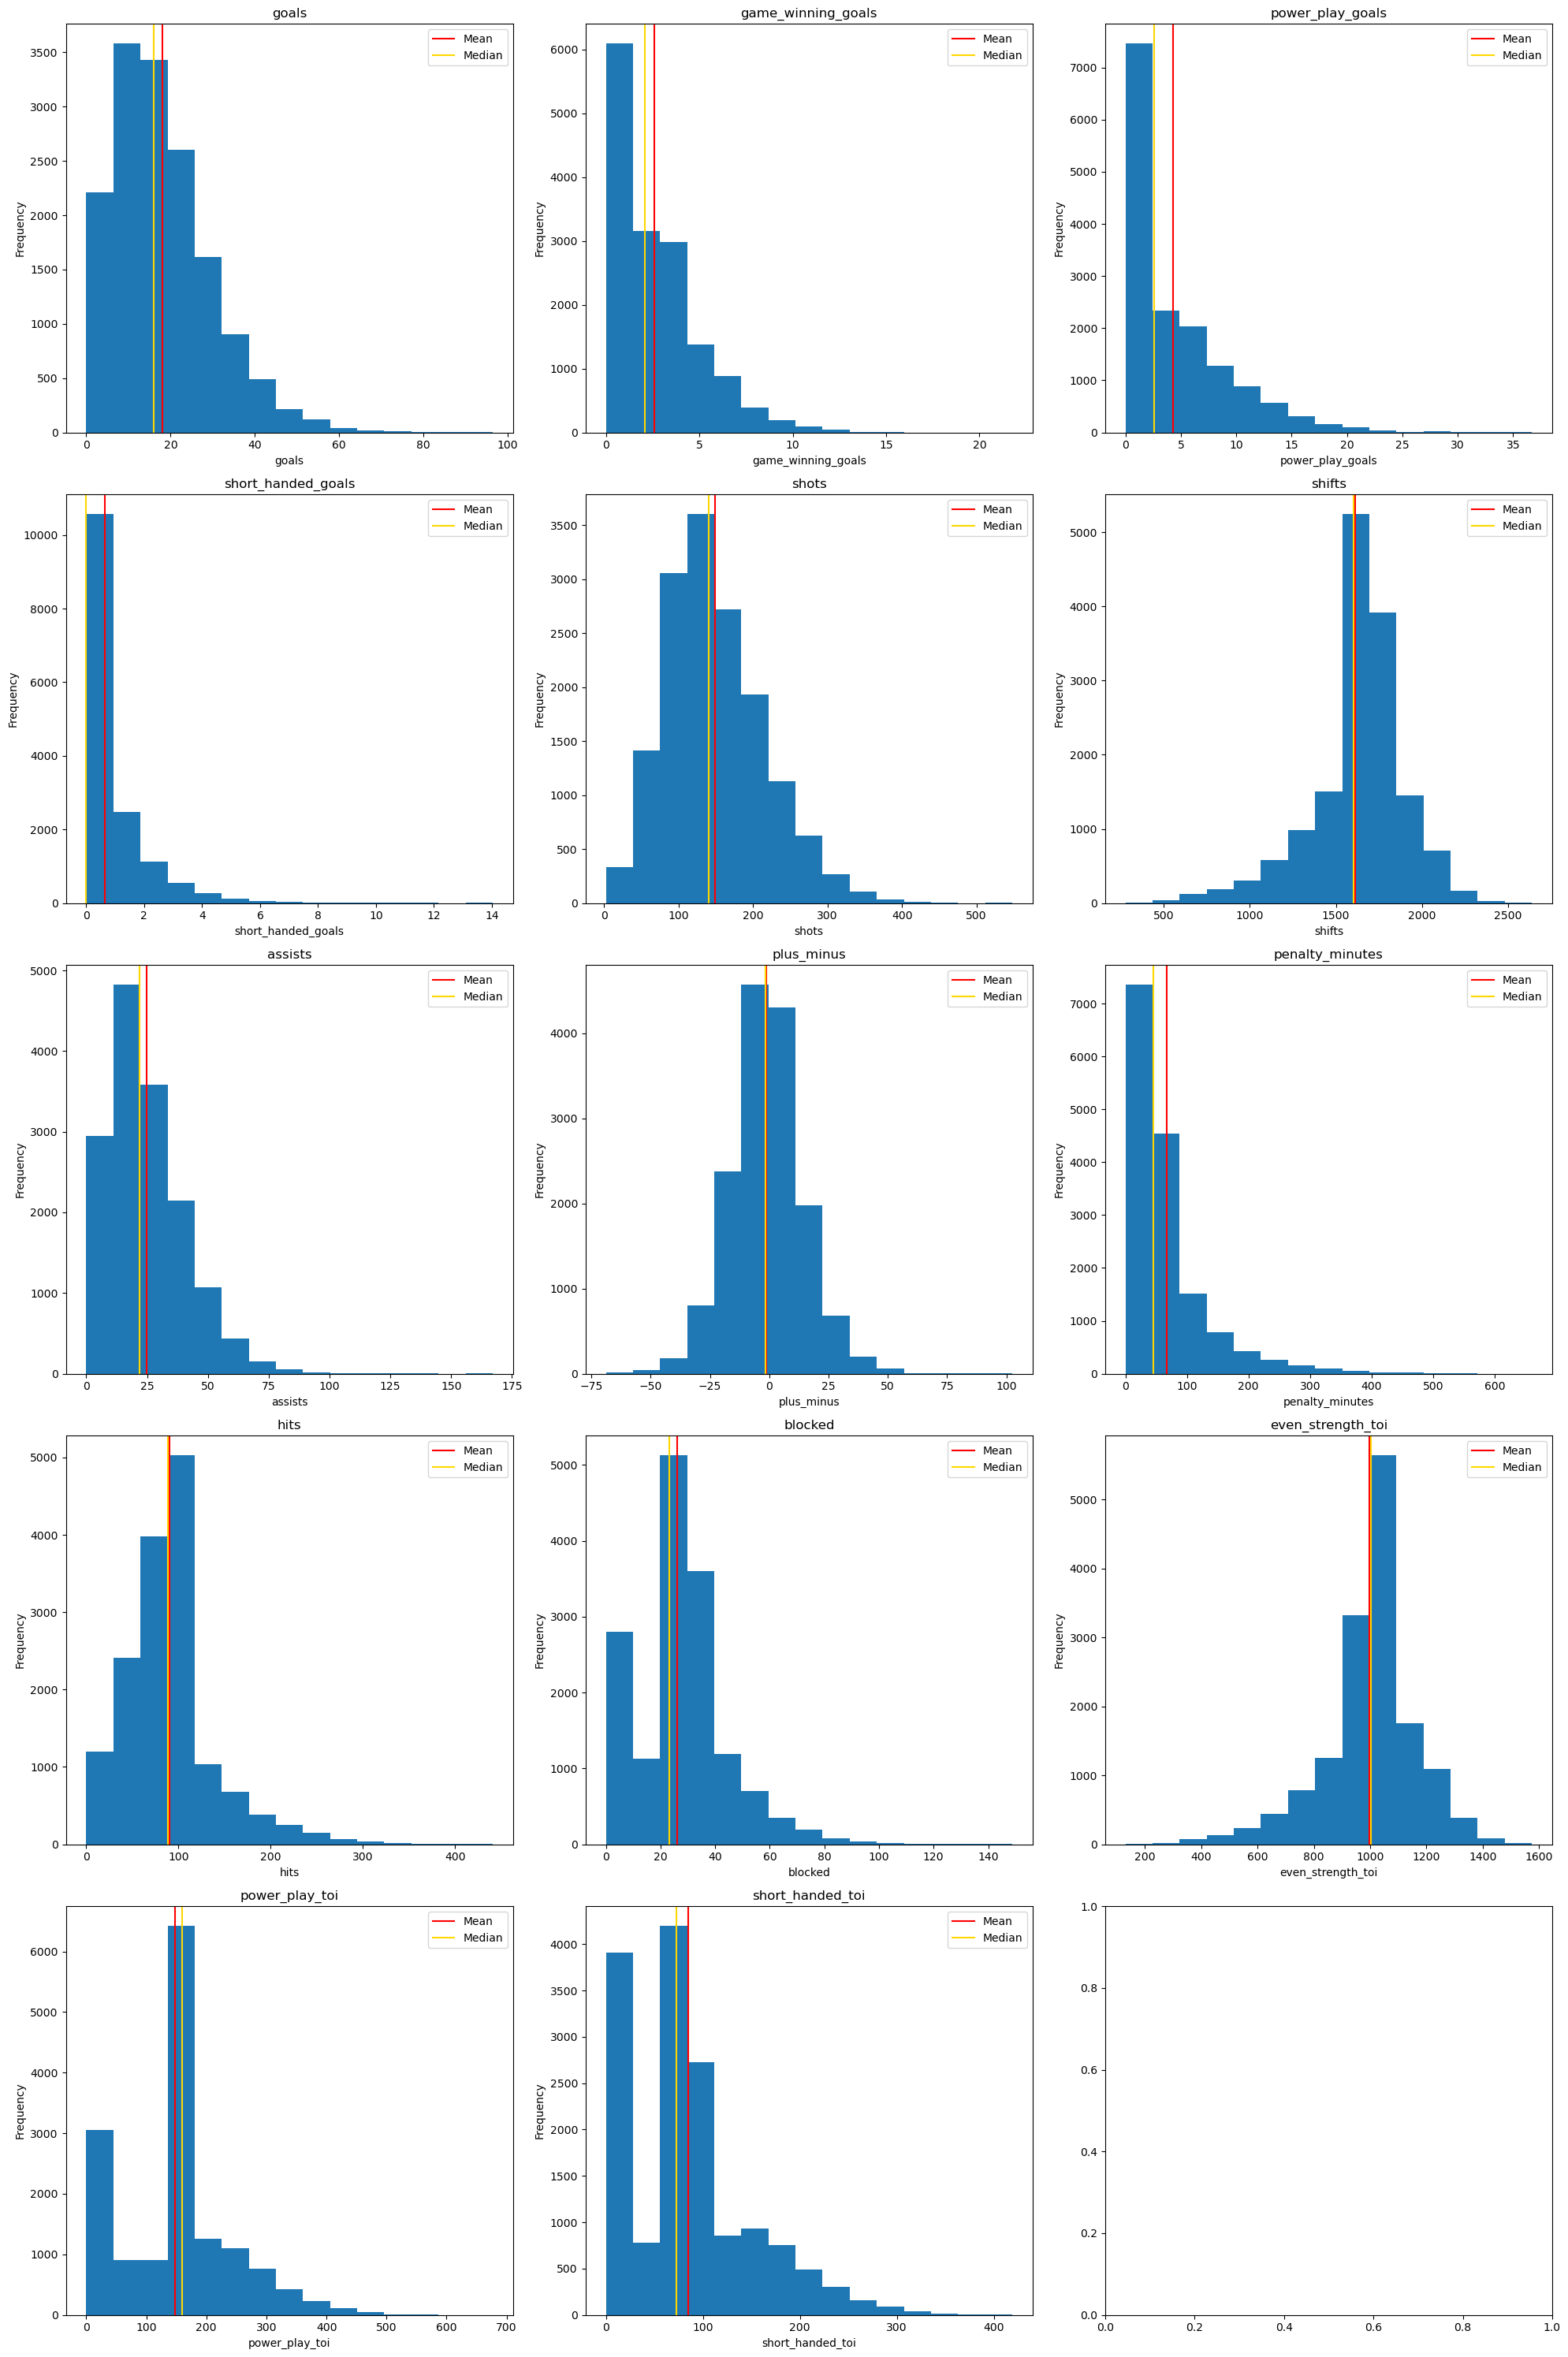

In [78]:
# replot distributions after computation

# plot will have 6 rows, 3 subplots per row
plt.subplots(5, 3, figsize=(20,30))

# Creating the for loop
for slot_num, each_column in enumerate(game_stats_avg.columns, start=1):
    
    # Creating a hist for every iteration
    plt.subplot(5,3,slot_num)
    plt.hist(game_stats_avg[each_column], bins=15)
    
    # Set the titles and labels
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    
    # Adding median and mean lines
    plt.axvline(game_stats_avg[each_column].mean(), c='red', label='Mean')
    plt.axvline(game_stats_avg[each_column].median(), c='gold', label='Median')
    plt.legend()

plt.tight_layout()

plt.show()

The new distributions look reasonable.  Recall that values of `hits`, `blocked`, `even_strength_toi`, `power_play_toi`, and `short_handed_toi` contain average values for the seasons prior to 1997-1998, which is when the NHL started tracking and publishing those stats.  This explains the abrupt peaks on these distributions.

Check the last few entries to validate the computation accuracy:

In [79]:
df.tail(15)[['player_id', 'name', 'shots', 'games_played', 'goals', 'assists', 'even_strength_toi']]

,player_id,name,shots,games_played,goals,assists,even_strength_toi
15229,8481554,Kaapo Kakko,125.000000,82,18.000000,22.000000,1146.250000
15230,8481559,Jack Hughes,165.344262,61,9.409836,18.819672,1039.087869
15231,8481559,Jack Hughes,207.928571,56,16.107143,29.285714,1316.583214
15232,8481559,Jack Hughes,276.122449,49,43.510204,50.204082,1362.488571
15233,8481559,Jack Hughes,353.230769,78,45.205128,58.871795,1372.942821
15234,8481624,Ilya Mikheyev,206.051282,39,16.820513,31.538462,1113.034359
15235,8481624,Ilya Mikheyev,162.481481,54,10.629630,15.185185,1023.602963
15236,8481624,Ilya Mikheyev,227.433962,53,32.490566,17.018868,1047.047170
15237,8481624,Ilya Mikheyev,162.217391,46,23.173913,26.739130,1150.103478
15238,8482109,Alexis Lafrenière,98.107143,56,17.571429,13.178571,1032.951071


### Calculate Exponentially-Weighted Moving Averages
It is anticipated that players will have up years and down years in terms of goal production.  Calculating the exponentially-weighted moving (EWM) averages of the gameplay statistics will mitigate the impact of a single up or down year on correctly predicting the following year's goal output, while also weighting the recent values more heavily in the calculation.

EWM averages can be calculated using the .ewm() function in pandas.  By setting span equal to 3, the function will look at the current entry, as well as the two preceeding ones, when calculating the average value.  If there are fewer than two preceeding entries for that player, the function will simply use the available datapoints to compute the average (i.e., span is inclusive).  Setting adjust to False means that the weighting of the averaging is based on the sequence of the datapoints.

In [80]:
# list of game_stats column names
game_stats_list = list(game_stats_avg.keys())

In [81]:
# sort the DF, to be sure
df = df.sort_values(['player_id', 'season_start_yr'])

In [82]:
# Function to apply EWM to each feature column
def apply_ewm(group):
    # create a copy of the data
    ewm_group = group.copy()
    for feature in game_stats_list:
        # calculate .ewm 
        ewm_group[feature + '_ewm'] = group[feature].ewm(span=3, adjust=False).mean()
    return ewm_group


To ensure EWM averages are calculate for each player individually, apply the `apply_ewm` function after grouping by `player_id`:

In [83]:
# Apply the function to each player individually
ewm_df = df.groupby('player_id').apply(apply_ewm)

# Resetting the index if needed
ewm_df.reset_index(drop=True, inplace=True)

# Display the result
print(ewm_df.shape)
ewm_df.tail(15)

(15244, 43)


,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm
15229,8481554,Kaapo Kakko,74,205,2022,21,4,NYR,0,0,0.144000,3.18,0,0,82,18.000000,2.000000,0.000000,0.000000,125.000000,1473.000000,22.000000,12.000000,8.000000,26.000000,27.000000,1146.250000,73.050000,35.870000,15.812115,2.419397,1.214434,0.000000,126.283045,1505.679792,19.971459,6.893444,13.077101,22.909597,25.776163,1112.157087,98.149829,27.336720
15230,8481559,Jack Hughes,71,175,2019,18,1,NJD,0,0,0.056911,3.02,11,56,61,9.409836,2.688525,5.377049,0.000000,165.344262,1484.065574,18.819672,-34.950820,13.442623,16.131148,28.229508,1039.087869,260.383607,1.478689,9.409836,2.688525,5.377049,0.000000,165.344262,1484.065574,18.819672,-34.950820,13.442623,16.131148,28.229508,1039.087869,260.383607,1.478689
15231,8481559,Jack Hughes,71,175,2020,19,2,NJD,0,0,0.077465,2.94,26,49,56,16.107143,1.464286,1.464286,0.000000,207.928571,1852.321429,29.285714,-4.392857,23.428571,21.964286,21.964286,1316.583214,242.602857,3.982857,12.758489,2.076405,3.420667,0.000000,186.636417,1668.193501,24.052693,-19.671838,18.435597,19.047717,25.096897,1177.835542,251.493232,2.730773
15232,8481559,Jack Hughes,71,175,2021,20,3,NJD,0,0,0.157576,3.14,43,78,49,43.510204,3.346939,10.040816,0.000000,276.122449,1820.734694,50.204082,-26.775510,0.000000,10.040816,25.102041,1362.488571,236.009388,5.907347,28.134347,2.711672,6.730742,0.000000,231.379433,1744.464098,37.128387,-23.223674,9.217799,14.544266,25.099469,1270.162056,243.751310,4.319060
15233,8481559,Jack Hughes,71,175,2022,21,4,NJD,0,0,0.127976,3.18,0,0,78,45.205128,6.307692,9.461538,0.000000,353.230769,1829.230769,58.871795,10.512821,6.307692,12.615385,31.538462,1372.942821,259.035897,5.235385,36.669737,4.509682,8.096140,0.000000,292.305101,1786.847433,48.000091,-6.355427,7.762745,13.579826,28.318965,1321.552439,251.393604,4.777222
15234,8481624,Ilya Mikheyev,74,192,2019,24,1,TOR,0,0,0.081633,3.02,7,54,39,16.820513,2.102564,0.000000,2.102564,206.051282,1791.384615,31.538462,14.717949,8.410256,54.666667,27.333333,1113.034359,6.412821,157.797436,16.820513,2.102564,0.000000,2.102564,206.051282,1791.384615,31.538462,14.717949,8.410256,54.666667,27.333333,1113.034359,6.412821,157.797436
15235,8481624,Ilya Mikheyev,74,192,2020,25,2,TOR,0,0,0.065421,2.94,21,53,54,10.629630,3.037037,0.000000,0.000000,162.481481,1594.444444,15.185185,7.592593,9.111111,74.407407,42.518519,1023.602963,11.616667,129.954815,13.725071,2.569801,0.000000,1.051282,184.266382,1692.914530,23.361823,11.155271,8.760684,64.537037,34.925926,1068.318661,9.014744,143.876125
15236,8481624,Ilya Mikheyev,74,192,2021,26,3,TOR,0,0,0.142857,3.14,13,46,53,32.490566,6.188679,6.188679,6.188679,227.433962,1709.622642,17.018868,24.754717,40.226415,80.452830,27.849057,1047.047170,89.627547,114.567925,23.107819,4.379240,3.094340,3.619981,205.850172,1701.268586,20.190346,17.954994,24.493549,72.494934,31.387491,1057.682915,49.321145,129.222025
15237,8481624,Ilya Mikheyev,74,192,2022,27,4,VAN,0,1,0.142857,3.18,0,0,46,23.173913,3.565217,1.782609,0.000000,162.217391,1845.000000,26.739130,5.347826,3.565217,23.173913,24.956522,1150.103478,121.752174,114.942609,23.140866,3.972229,2.438474,1.809990,184.033782,1773.134293,23.464738,11.651410,14.029383,47.834423,28.172007,1103.893197,85.536660,122.082317
15238,8482109,Alexis Lafrenière,73,194,2020,18,1,NYR,0,0,0.179104,2.94,19,79,56,17.571429,5.857143,0.000000,0.000000,98.107143,1493.571429,13.178571,-10.250000,11.714286,62.964286,16.107143,1032.951071,1

### Calculate Simple Moving Average
For the shot_pct feature, apply a cumulative moving average with the .expanding() fucntion.  A cumulative moving average is simple average of all preceeding values.

In [84]:
# create a copy
df2 = ewm_df.copy()

In [85]:
# Group by player, perform weighted average calculation with lambda
df2 = df2.groupby('player_id').apply(lambda x: x.assign( \
                                                        shot_pct_ewm=x['goals'].expanding().sum() \
                                                        /x['shots'].expanding().sum()))

# Resetting the index if needed
df2.reset_index(drop=True, inplace=True)

# Display the result
df2

,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm
0,8444894,Greg Adams,76,196,1984,21,1,NJD,0,0,0.184615,3.89,35,78,36,27.333333,0.000000,11.388889,0.000000,148.055556,1568.691523,20.500000,-31.888889,20.500000,98.745129,23.262131,982.497678,139.441657,72.656687,27.333333,0.000000,11.388889,0.000000,148.055556,1568.691523,20.500000,-31.888889,20.500000,98.745129,23.262131,982.497678,139.441657,72.656687,0.184615
1,8444894,Greg Adams,76,196,1985,22,2,NJD,0,0,0.173267,3.97,20,72,78,36.794872,2.102564,10.512821,0.000000,212.358974,1568.691523,44.153846,-7.358974,31.538462,98.745129,23.262131,982.497678,139.441657,72.656687,32.064103,1.051282,10.950855,0.000000,180.207265,1568.691523,32.326923,-19.623932,26.019231,98.745129,23.262131,982.497678,139.441657,72.656687,0.177929
2,8444894,Greg Adams,76,196,1986,23,3,NJD,0,0,0.142857,3.67,36,80,72,22.777778,1.138889,6.833333,0.000000,159.444444,1568.691523,30.750000,-18.222222,21.638889,98.745129,23.262131,982.497678,139.441657,72.656687,27.420940,1.095085,8.892094,0.000000,169.825855,1568.691523,31.538462,-18.923077,23.829060,98.745129,23.262131,982.497678,139.441657,72.656687,0.167172
3,8444894,Greg Adams,76,196,1987,24,4,VAN,0,1,0.158590,3.71,19,61,80,36.900000,3.075000,12.300000,0.000000,232.675000,1568.691523,41.000000,-24.600000,30.750000,98.745129,23.262131,982.497678,139.441657,72.656687,32.160470,2.085043,10.596047,0.000000,201.250427,1568.691523,36.269231,-21.761538,27.289530,98.745129,23.262131,982.497678,139.441657,72.656687,0.164519
4,8444894,Greg Adams,76,196,1988,25,5,VAN,0,0,0.131944,3.74,30,65,61,25.540984,2.688525,12.098361,0.000000,193.573770,1568.691523,18.819672,-28.229508,32.262295,98.745129,23.262131,982.497678,139.441657,72.656687,28.850727,2.386784,11.347204,0.000000,197.412099,1568.691523,27.544451,-24.995523,29.775912,98.745129,23.262131,982.497678,139.441657,72.656687,0.157854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15239,8482109,Alexis Lafrenière,73,194,2021,19,2,NYR,0,0,0.172727,3.14,16,81,79,19.721519,4.151899,0.000000,0.000000,114.177215,1429.291139,12.455696,2.075949,38.405063,112.101266,26.987342,1046.870127,96.977975,3.425316,18.646474,5.004521,0.000000,0.000000,106.142179,1461.431284,12.817134,-4.087025,25.059675,87.532776,21.547242,1039.910599,100.925059,1.983551,0.175674
15240,8482109,Alexis Lafrenière,73,194,2022,20,3,NYR,0,0,0.118519,3.18,0,0,81,16.197531,2.024691,3.037037,0.000000,136.666667,1422.345679,23.283951,10.123457,33.407407,142.740741,28.345679,1132.581975,112.755062,2.662469,17.422002,3.514606,1.518519,0.000000,121.404423,1441.888481,18.050542,3.018216,29.233541,115.136758,24.946461,1086.246287,106.840060,2.323010,0.153289
15241,8482116,Tim Stützle,72,197,2020,18,1,OTT,0,0,0.108108,2.94,22,79,53,18.566038,3.094340,6.188679,0.000000,171.735849,1565.735849,26.301887,-27.849057,21.660377,77.358491,23.207547,1055.324528,235.324528,0.000000,18.566038,3.094340,6.188679,0.000000,171.735849,1565.735849,26.301887,-27.849057,21.660377,77.358491,23.207547,1055.324528,235.324528,0.000000,0.108108
15242,8482116,Tim Stützle,72,197,2021,19,2,OTT,0,0,0.125000,3.14,39,78,79,22.835443,4.151899,7.265823,1.037975,182.683544,1741.721519,37.367089,-28.025316,38.405063,129.746835,53.974684,1233.165823,265.773418,10.794937,20.700740,3.623119,6.727251,0.518987,177.209697,1653.728684,31.834488,-

In [86]:
# round float values to 2 decimal places
df2.iloc[:, 15:43] = df2.iloc[:, 15:43].round(2)
df2

,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm
0,8444894,Greg Adams,76,196,1984,21,1,NJD,0,0,0.184615,3.89,35,78,36,27.33,0.00,11.39,0.00,148.06,1568.69,20.50,-31.89,20.50,98.75,23.26,982.50,139.44,72.66,27.33,0.00,11.39,0.00,148.06,1568.69,20.50,-31.89,20.50,98.75,23.26,982.50,139.44,72.66,0.184615
1,8444894,Greg Adams,76,196,1985,22,2,NJD,0,0,0.173267,3.97,20,72,78,36.79,2.10,10.51,0.00,212.36,1568.69,44.15,-7.36,31.54,98.75,23.26,982.50,139.44,72.66,32.06,1.05,10.95,0.00,180.21,1568.69,32.33,-19.62,26.02,98.75,23.26,982.50,139.44,72.66,0.177929
2,8444894,Greg Adams,76,196,1986,23,3,NJD,0,0,0.142857,3.67,36,80,72,22.78,1.14,6.83,0.00,159.44,1568.69,30.75,-18.22,21.64,98.75,23.26,982.50,139.44,72.66,27.42,1.10,8.89,0.00,169.83,1568.69,31.54,-18.92,23.83,98.75,23.26,982.50,139.44,72.66,0.167172
3,8444894,Greg Adams,76,196,1987,24,4,VAN,0,1,0.158590,3.71,19,61,80,36.90,3.08,12.30,0.00,232.68,1568.69,41.00,-24.60,30.75,98.75,23.26,982.50,139.44,72.66,32.16,2.09,10.60,0.00,201.25,1568.69,36.27,-21.76,27.29,98.75,23.26,982.50,139.44,72.66,0.164519
4,8444894,Greg Adams,76,196,1988,25,5,VAN,0,0,0.131944,3.74,30,65,61,25.54,2.69,12.10,0.00,193.57,1568.69,18.82,-28.23,32.26,98.75,23.26,982.50,139.44,72.66,28.85,2.39,11.35,0.00,197.41,1568.69,27.54,-25.00,29.78,98.75,23.26,982.50,139.44,72.66,0.157854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15239,8482109,Alexis Lafrenière,73,194,2021,19,2,NYR,0,0,0.172727,3.14,16,81,79,19.72,4.15,0.00,0.00,114.18,1429.29,12.46,2.08,38.41,112.10,26.99,1046.87,96.98,3.43,18.65,5.00,0.00,0.00,106.14,1461.43,12.82,-4.09,25.06,87.53,21.55,1039.91,100.93,1.98,0.175674
15240,8482109,Alexis Lafrenière,73,194,2022,20,3,NYR,0,0,0.118519,3.18,0,0,81,16.20,2.02,3.04,0.00,136.67,1422.35,23.28,10.12,33.41,142.74,28.35,1132.58,112.76,2.66,17.42,3.51,1.52,0.00,121.40,1441.89,18.05,3.02,29.23,115.14,24.95,1086.25,106.84,2.32,0.153289
15241,8482116,Tim Stützle,72,197,2020,18,1,OTT,0,0,0.108108,2.94,22,79,53,18.57,3.09,6.19,0.00,171.74,1565.74,26.30,-27.85,21.66,77.36,23.21,1055.32,235.32,0.00,18.57,3.09,6.19,0.00,171.74,1565.74,26.30,-27.85,21.66,77.36,23.21,1055.32,235.32,0.00,0.108108
15242,8482116,Tim Stützle,72,197,2021,19,2,OTT,0,0,0.125000,3.14,39,78,79,22.84,4.15,7.27,1.04,182.68,1741.72,37.37,-28.03,38.41,129.75,53.97,1233.17,265.77,10.79,20.70,3.62,6.73,0.52,177.21,1653.73,31.83,-27.94,30.03,103.55,38.59,1144.25,250.55,5.40,0.116815


## Target Feature & Unique Identifier <a class="anchor" id="part3" ></a>

The target feature is the values contained in `goals_ref`, prorated to a full 82-game season relative to the values contained in `games_played_ref`.

### Drop Rows Without Target Feature
If `games_played_ref` is 0, we want to drop that row.  Use .where() function to fill entries where `games_played_ref` is zero with null values, then drop entries with null values.

In [87]:
# making boolean series for 'games_played_ref'
filter1 = df2['games_played_ref']>0

# filtering data on basis of filter 
df2.where(filter1, inplace = True) 

print(df2.shape)
df2.tail(15)

(15244, 44)


,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm
15229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15230,8481559.0,Jack Hughes,71.0,175.0,2019.0,18.0,1.0,NJD,0.0,0.0,0.056911,3.02,11.0,56.0,61.0,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,0.056911
15231,8481559.0,Jack Hughes,71.0,175.0,2020.0,19.0,2.0,NJD,0.0,0.0,0.077465,2.94,26.0,49.0,56.0,16.11,1.46,1.46,0.00,207.93,1852.32,29.29,-4.39,23.43,21.96,21.96,1316.58,242.60,3.98,12.76,2.08,3.42,0.00,186.64,1668.19,24.05,-19.67,18.44,19.05,25.10,1177.84,251.49,2.73,0.068360
15232,8481559.0,Jack Hughes,71.0,175.0,2021.0,20.0,3.0,NJD,0.0,0.0,0.157576,3.14,43.0,78.0,49.0,43.51,3.35,10.04,0.00,276.12,1820.73,50.20,-26.78,0.00,10.04,25.10,1362.49,236.01,5.91,28.13,2.71,6.73,0.00,231.38,1744.46,37.13,-23.22,9.22,14.54,25.10,1270.16,243.75,4.32,0.106295
15233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15234,8481624.0,Ilya Mikheyev,74.0,192.0,2019.0,24.0,1.0,TOR,0.0,0.0,0.081633,3.02,7.0,54.0,39.0,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,0.081633
15235,8481624.0,Ilya Mikheyev,74.0,192.0,2020.0,25.0,2.0,TOR,0.0,0.0,0.065421,2.94,21.0,53.0,54.0,10.63,3.04,0.00,0.00,162.48,1594.44,15.19,7.59,9.11,74.41,42.52,1023.60,11.62,129.95,13.73,2.57,0.00,1.05,184.27,1692.91,23.36,11.16,8.76,64.54,34.93,1068.32,9.01,143.88,0.074485
15236,8481624.0,Ilya Mikheyev,74.0,192.0,2021.0,26.0,3.0,TOR,0.0,0.0,0.142857,3.14,13.0,46.0,53.0,32.49,6.19,6.19,6.19,227.43,1709.62,17.02,24.75,40.23,80.45,27.85,1047.05,89.63,114.57,23.11,4.38,3.09,3.62,205.85,1701.27,20.19,17.95,24.49,72.49,31.39,1057.68,49.32,129.22,0.100577
15237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15238,8482109.0,Alexis Lafrenière,73.0,194.0,2020.0,18.0,1.0,NYR,0.0,0.0,0.179104,2.94,19.0,79.0,56.0,17.57,5.86,0.00,0.00,98.11,1493.57,13.18,-10.25,11.71,62.96,16.11,1032.95,104.87,0.54,17.57,5.86,0.00,0.00,98.11,1493.57,13.18,-10.25,11.71,62.96,16.11,1032.95,104.87,0.54,0.179104


In [88]:
# drop null values
df2.dropna(inplace=True)

# check result
print(df2.shape)
df2.tail(15)

(13503, 44)


,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm
15223,8481533.0,Trevor Zegras,72.0,185.0,2020.0,19.0,1.0,ANA,0.0,0.0,0.056604,2.94,23.0,75.0,24.0,10.25,0.00,0.00,0.00,181.08,1588.75,34.17,20.50,41.00,23.92,13.67,1084.18,176.98,1.43,10.25,0.00,0.00,0.00,181.08,1588.75,34.17,20.50,41.00,23.92,13.67,1084.18,176.98,1.43,0.056604
15224,8481533.0,Trevor Zegras,72.0,185.0,2021.0,20.0,2.0,ANA,0.0,0.0,0.127072,3.14,23.0,81.0,75.0,25.15,5.47,9.84,0.00,197.89,1727.47,41.55,-22.96,54.67,61.23,29.52,1251.70,215.47,1.20,17.70,2.73,4.92,0.00,189.49,1658.11,37.86,-1.23,47.83,42.57,21.59,1167.94,196.23,1.32,0.093401
15226,8481554.0,Kaapo Kakko,74.0,205.0,2019.0,18.0,1.0,NYR,0.0,0.0,0.091743,3.02,9.0,48.0,66.0,12.42,3.73,2.48,0.00,135.42,1464.82,16.15,-32.30,17.39,24.85,13.67,986.67,182.66,1.53,12.42,3.73,2.48,0.00,135.42,1464.82,16.15,-32.30,17.39,24.85,13.67,986.67,182.66,1.53,0.091743
15227,8481554.0,Kaapo Kakko,74.0,205.0,2020.0,19.0,2.0,NYR,0.0,0.0,0.111111,2.94,7.0,43.0,48.0,15.38,0.00,3.42,0.00,138.38,1530.67,13.67,5.12,17.08,23.92,27.33,1068.22,108.27,0.00,13.90,1.86,2.95,0.00,136.90,1497.74,14.91,-13.59,17.24,24.38,20.50,1027.45,145.47,0.76,0.101531
15228,8481554.0,Kaapo Kakko,74.0,205.0,2021.0,20.0,3.0,NYR,0.0,0.0,0.112903,3.14,18.0,82.0,43.0,13.35,3.81,1.91,0.00,118.23,1578.98,20.98,17.16,19.07,15.26,28.60,1128.68,101.03,36.84,13.62,2.84,2.43,0.00,127.57,1538.36,17.94,1.79,18.15,19.82,24.55,1078.06,123.25,18.80,0.104961
15230,8481559.0,Jack Hughes,71.0,175.0,2019.0,18.0,1.0,NJD,0.0,0.0,0.056911,3.02,11.0,56.0,61.0,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,0.056911
15231,8481559.0,Jack Hughes,71.0,175.0,2020.0,19.0,2.0,NJD,0.0,0.0,0.077465,2.94,26.0,49.0,56.0,16.11,1.46,1.46,0.00,207.93,1852.32,29.29,-4.39,23.43,21.96,21.96,1316.58,242.60,3.98,12.76,2.08,3.42,0.00,186.64,1668.19,24.05,-19.67,18.44,19.05,25.10,1177.84,251.49,2.73,0.068360
15232,8481559.0,Jack Hughes,71.0,175.0,2021.0,20.0,3.0,NJD,0.0,0.0,0.157576,3.14,43.0,78.0,49.0,43.51,3.35,10.04,0.00,276.12,1820.73,50.20,-26.78,0.00,10.04,25.10,1362.49,236.01,5.91,28.13,2.71,6.73,0.00,231.38,1744.46,37.13,-23.22,9.22,14.54,25.10,1270.16,243.75,4.32,0.106295
15234,8481624.0,Ilya Mikheyev,74.0,192.0,2019.0,24.0,1.0,TOR,0.0,0.0,0.081633,3.02,7.0,54.0,39.0,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,0.081633
15235,8481624.0,Ilya Mikheyev,74.0,192.0,2020.0,25.0,2.0,TOR,0.0,0.0,0.065421,2.94,21.0,53.0,54.0,10.63,3.04,0.00,0.00,162.48,1594.44,15.19,7.59,9.11,74.41,42.52,1023.60,11.62,129.95,13.73,2.57,0.00,1.05,184.27,1692.91,23.36,11.16,8.76,64.54,34.93,1068.32,9.01,143.88,0.074485


### Calculate Target Feature from Reference Columns
Use `goals_ref` and `games_played_ref` to calculate the player's goal total prorated for a full 82-game season.

In [89]:
# instantiate 'target' feature and populate with calculated values
df2['target'] = (df2['goals_ref'] * 82) / df2['games_played_ref']

# round calculated values and then convert to integers
df2['target'] = df2['target'].round().astype(int)

# check values
df2.tail(15)[['player_id', 'name', 'goals_ref', 'games_played_ref', 'target']]

,player_id,name,goals_ref,games_played_ref,target
15223,8481533.0,Trevor Zegras,23.0,75.0,25
15224,8481533.0,Trevor Zegras,23.0,81.0,23
15226,8481554.0,Kaapo Kakko,9.0,48.0,15
15227,8481554.0,Kaapo Kakko,7.0,43.0,13
15228,8481554.0,Kaapo Kakko,18.0,82.0,18
15230,8481559.0,Jack Hughes,11.0,56.0,16
15231,8481559.0,Jack Hughes,26.0,49.0,44
15232,8481559.0,Jack Hughes,43.0,78.0,45
15234,8481624.0,Ilya Mikheyev,7.0,54.0,11
15235,8481624.0,Ilya Mikheyev,21.0,53.0,32


### Add Primary Key
Currently the only primary key in the DataFrame is the index, which can be accidentally dropped or changed when manipulating the DataFrame.  Add in a primary key that will act as the unique identifier of a given entry.  The value will be a combination of `player_id` and `season_start_yr`, which is how the DataFrame is natively sorted.  First re-sort the DataFrame to be safe:

In [90]:
# sort values, to be sure
df2 = df2.sort_values(by=['player_id', 'season_start_yr'])

# reset index, to be sure
df2.reset_index(drop=True, inplace=True)

# check the shape and tail...for sanity
print(df2.shape)
df2.tail(15)

(13503, 45)


,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm,target
13488,8481533.0,Trevor Zegras,72.0,185.0,2020.0,19.0,1.0,ANA,0.0,0.0,0.056604,2.94,23.0,75.0,24.0,10.25,0.00,0.00,0.00,181.08,1588.75,34.17,20.50,41.00,23.92,13.67,1084.18,176.98,1.43,10.25,0.00,0.00,0.00,181.08,1588.75,34.17,20.50,41.00,23.92,13.67,1084.18,176.98,1.43,0.056604,25
13489,8481533.0,Trevor Zegras,72.0,185.0,2021.0,20.0,2.0,ANA,0.0,0.0,0.127072,3.14,23.0,81.0,75.0,25.15,5.47,9.84,0.00,197.89,1727.47,41.55,-22.96,54.67,61.23,29.52,1251.70,215.47,1.20,17.70,2.73,4.92,0.00,189.49,1658.11,37.86,-1.23,47.83,42.57,21.59,1167.94,196.23,1.32,0.093401,23
13490,8481554.0,Kaapo Kakko,74.0,205.0,2019.0,18.0,1.0,NYR,0.0,0.0,0.091743,3.02,9.0,48.0,66.0,12.42,3.73,2.48,0.00,135.42,1464.82,16.15,-32.30,17.39,24.85,13.67,986.67,182.66,1.53,12.42,3.73,2.48,0.00,135.42,1464.82,16.15,-32.30,17.39,24.85,13.67,986.67,182.66,1.53,0.091743,15
13491,8481554.0,Kaapo Kakko,74.0,205.0,2020.0,19.0,2.0,NYR,0.0,0.0,0.111111,2.94,7.0,43.0,48.0,15.38,0.00,3.42,0.00,138.38,1530.67,13.67,5.12,17.08,23.92,27.33,1068.22,108.27,0.00,13.90,1.86,2.95,0.00,136.90,1497.74,14.91,-13.59,17.24,24.38,20.50,1027.45,145.47,0.76,0.101531,13
13492,8481554.0,Kaapo Kakko,74.0,205.0,2021.0,20.0,3.0,NYR,0.0,0.0,0.112903,3.14,18.0,82.0,43.0,13.35,3.81,1.91,0.00,118.23,1578.98,20.98,17.16,19.07,15.26,28.60,1128.68,101.03,36.84,13.62,2.84,2.43,0.00,127.57,1538.36,17.94,1.79,18.15,19.82,24.55,1078.06,123.25,18.80,0.104961,18
13493,8481559.0,Jack Hughes,71.0,175.0,2019.0,18.0,1.0,NJD,0.0,0.0,0.056911,3.02,11.0,56.0,61.0,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,9.41,2.69,5.38,0.00,165.34,1484.07,18.82,-34.95,13.44,16.13,28.23,1039.09,260.38,1.48,0.056911,16
13494,8481559.0,Jack Hughes,71.0,175.0,2020.0,19.0,2.0,NJD,0.0,0.0,0.077465,2.94,26.0,49.0,56.0,16.11,1.46,1.46,0.00,207.93,1852.32,29.29,-4.39,23.43,21.96,21.96,1316.58,242.60,3.98,12.76,2.08,3.42,0.00,186.64,1668.19,24.05,-19.67,18.44,19.05,25.10,1177.84,251.49,2.73,0.068360,44
13495,8481559.0,Jack Hughes,71.0,175.0,2021.0,20.0,3.0,NJD,0.0,0.0,0.157576,3.14,43.0,78.0,49.0,43.51,3.35,10.04,0.00,276.12,1820.73,50.20,-26.78,0.00,10.04,25.10,1362.49,236.01,5.91,28.13,2.71,6.73,0.00,231.38,1744.46,37.13,-23.22,9.22,14.54,25.10,1270.16,243.75,4.32,0.106295,45
13496,8481624.0,Ilya Mikheyev,74.0,192.0,2019.0,24.0,1.0,TOR,0.0,0.0,0.081633,3.02,7.0,54.0,39.0,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,16.82,2.10,0.00,2.10,206.05,1791.38,31.54,14.72,8.41,54.67,27.33,1113.03,6.41,157.80,0.081633,11
13497,8481624.0,Ilya Mikheyev,74.0,192.0,2020.0,25.0,2.0,TOR,0.0,0.0,0.065421,2.94,21.0,53.0,54.0,10.63,3.04,0.00,0.00,162.48,1594.44,15.19,7.59,9.11,74.41,42.52,1023.60,11.62,129.95,13.73,2.57,0.00,1.05,184.27,1692.91,23.36,11.16,8.76,64.54,34.93,1068.32,9.01,143.88,0.074485,32


Double check the datatype of the `player_id` and `season_start_yr` columns:

In [91]:
# check datatypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13503 entries, 0 to 13502
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               13503 non-null  float64
 1   name                    13503 non-null  object 
 2   height                  13503 non-null  float64
 3   weight                  13503 non-null  float64
 4   season_start_yr         13503 non-null  float64
 5   player_age              13503 non-null  float64
 6   season_num              13503 non-null  float64
 7   franchise               13503 non-null  object 
 8   midseason_trades        13503 non-null  float64
 9   offseason_trade         13503 non-null  float64
 10  shot_pct                13503 non-null  float64
 11  league_goal/game        13503 non-null  float64
 12  goals_ref               13503 non-null  float64
 13  games_played_ref        13503 non-null  float64
 14  games_played            13503 non-null

The value of `player_id` and `season_start_yr` are stored as float, as well as several other features that should be integer values.  Convert datatype of offending columns:

In [92]:
# features to be int
integer_features_list = ['player_id', 'height', 'weight', 'season_start_yr', 'player_age', \
                        'midseason_trades', 'offseason_trade', 'goals_ref', 'games_played_ref', \
                        'games_played']

# convert to integer
df2[integer_features_list] = df2[integer_features_list].astype(int)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13503 entries, 0 to 13502
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               13503 non-null  int32  
 1   name                    13503 non-null  object 
 2   height                  13503 non-null  int32  
 3   weight                  13503 non-null  int32  
 4   season_start_yr         13503 non-null  int32  
 5   player_age              13503 non-null  int32  
 6   season_num              13503 non-null  float64
 7   franchise               13503 non-null  object 
 8   midseason_trades        13503 non-null  int32  
 9   offseason_trade         13503 non-null  int32  
 10  shot_pct                13503 non-null  float64
 11  league_goal/game        13503 non-null  float64
 12  goals_ref               13503 non-null  int32  
 13  games_played_ref        13503 non-null  int32  
 14  games_played            13503 non-null

Values of `player_id` are unnecessarily large - subtract 8,400,000 from each one:

In [93]:
# shorten 'player_id' values
df2['player_id'] = df2['player_id'] - 8400000

In [94]:
# instantiate 'unique_id' feature and populate with calculated values
# values of 'unique_id' are string concatenations of 'player_id' and 'season_start_yr'
df2['unique_id'] = df2.apply(lambda row: f"{row['player_id']}{row['season_start_yr']}", axis=1)

# confirm integer datatype
df2['unique_id'] = df2['unique_id'].astype(int)

In [95]:
# Check that 'unique_id' creates same sorting order
df2 = df2.sort_values(by=['unique_id'])
df2

,player_id,name,height,weight,season_start_yr,player_age,season_num,franchise,midseason_trades,offseason_trade,shot_pct,league_goal/game,goals_ref,games_played_ref,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,shifts,assists,plus_minus,penalty_minutes,hits,blocked,even_strength_toi,power_play_toi,short_handed_toi,goals_ewm,game_winning_goals_ewm,power_play_goals_ewm,short_handed_goals_ewm,shots_ewm,shifts_ewm,assists_ewm,plus_minus_ewm,penalty_minutes_ewm,hits_ewm,blocked_ewm,even_strength_toi_ewm,power_play_toi_ewm,short_handed_toi_ewm,shot_pct_ewm,target,unique_id
0,44894,Greg Adams,76,196,1984,21,1.0,NJD,0,0,0.184615,3.89,35,78,36,27.33,0.00,11.39,0.00,148.06,1568.69,20.50,-31.89,20.50,98.75,23.26,982.50,139.44,72.66,27.33,0.00,11.39,0.00,148.06,1568.69,20.50,-31.89,20.50,98.75,23.26,982.50,139.44,72.66,0.184615,37,448941984
1,44894,Greg Adams,76,196,1985,22,2.0,NJD,0,0,0.173267,3.97,20,72,78,36.79,2.10,10.51,0.00,212.36,1568.69,44.15,-7.36,31.54,98.75,23.26,982.50,139.44,72.66,32.06,1.05,10.95,0.00,180.21,1568.69,32.33,-19.62,26.02,98.75,23.26,982.50,139.44,72.66,0.177929,23,448941985
2,44894,Greg Adams,76,196,1986,23,3.0,NJD,0,0,0.142857,3.67,36,80,72,22.78,1.14,6.83,0.00,159.44,1568.69,30.75,-18.22,21.64,98.75,23.26,982.50,139.44,72.66,27.42,1.10,8.89,0.00,169.83,1568.69,31.54,-18.92,23.83,98.75,23.26,982.50,139.44,72.66,0.167172,37,448941986
3,44894,Greg Adams,76,196,1987,24,4.0,VAN,0,1,0.158590,3.71,19,61,80,36.90,3.08,12.30,0.00,232.68,1568.69,41.00,-24.60,30.75,98.75,23.26,982.50,139.44,72.66,32.16,2.09,10.60,0.00,201.25,1568.69,36.27,-21.76,27.29,98.75,23.26,982.50,139.44,72.66,0.164519,26,448941987
4,44894,Greg Adams,76,196,1988,25,5.0,VAN,0,0,0.131944,3.74,30,65,61,25.54,2.69,12.10,0.00,193.57,1568.69,18.82,-28.23,32.26,98.75,23.26,982.50,139.44,72.66,28.85,2.39,11.35,0.00,197.41,1568.69,27.54,-25.00,29.78,98.75,23.26,982.50,139.44,72.66,0.157854,38,448941988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13498,81624,Ilya Mikheyev,74,192,2021,26,3.0,TOR,0,0,0.142857,3.14,13,46,53,32.49,6.19,6.19,6.19,227.43,1709.62,17.02,24.75,40.23,80.45,27.85,1047.05,89.63,114.57,23.11,4.38,3.09,3.62,205.85,1701.27,20.19,17.95,24.49,72.49,31.39,1057.68,49.32,129.22,0.100577,23,816242021
13499,82109,Alexis Lafrenière,73,194,2020,18,1.0,NYR,0,0,0.179104,2.94,19,79,56,17.57,5.86,0.00,0.00,98.11,1493.57,13.18,-10.25,11.71,62.96,16.11,1032.95,104.87,0.54,17.57,5.86,0.00,0.00,98.11,1493.57,13.18,-10.25,11.71,62.96,16.11,1032.95,104.87,0.54,0.179104,20,821092020
13500,82109,Alexis Lafrenière,73,194,2021,19,2.0,NYR,0,0,0.172727,3.14,16,81,79,19.72,4.15,0.00,0.00,114.18,1429.29,12.46,2.08,38.41,112.10,26.99,1046.87,96.98,3.43,18.65,5.00,0.00,0.00,106.14,1461.43,12.82,-4.09,25.06,87.53,21.55,1039.91,100.93,1.98,0.175674,16,821092021
13501,82116,Tim Stützle,72,197,2020,18,1.0,OTT,0,0,0.108108,2.94,22,79,53,18.57,3.09,6.19,0.00,171.74,1565.74,26.30,-27.85,21.66,77.36,23.21,1055.32,235.32,0.00,18.57,3.09,6.19,0.00,171.74,1565.74,26.30,-27.85,21.66,77.36,23.21,1055.32,235.32,0.00,0.108108,23,821162020


## Encoding Categorical Columns <a class="anchor" id="part4" ></a>

### Binary Encoding
Use a map to binary encode the values of `mideason_trades`:  values of 0 will remain 0, anything above 0 assigned a value of 1.

In [96]:
# rename column
df2 = df2.rename(columns={'midseason_trades': 'midseason_trade'})

In [97]:
# check value counts
df2['midseason_trade'].value_counts()

midseason_trade
0    12105
1     1347
2       50
3        1
Name: count, dtype: int64

In [98]:
# map values of 'midseason_trade'
df2['midseason_trade'] = df2['midseason_trade'].map({0: 0, 1: 1, 2: 1, 3: 1})

In [99]:
# sanity check
df2['midseason_trade'].value_counts()

midseason_trade
0    12105
1     1398
Name: count, dtype: int64

### One-Hot Encoding
Use OneHotEncoder from sklearn to convert the categorical features `franchise` and `position_name` to numerical features.  

***This was originally completed but is now unnecessary because `franchise` values were found to be statistically insignificant, and `defensemen` have been removed from the dataset.  The code has been left here in case it is of use in future analyses***

In [100]:
# # import necessary library
# from sklearn.preprocessing import OneHotEncoder

In [101]:
# # Instantiate the OneHotEncoder
# ohe = OneHotEncoder()

# # Fit the OneHotEncoder to 'franchise' column
# # It expects a 2D array, so we first convert the column into a DataFrame
# franchise = pd.DataFrame(df['franchise'])
# encoded = ohe.fit_transform(franchise)
# encoded

In [102]:
# # Convert from sparse matrix to dense
# dense_array = encoded.toarray()
# dense_array

In [103]:
# # check list of franchises
# ohe.categories_

In [104]:
# # Put into a dataframe to get column names
# franchise_encoded = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
# franchise_encoded

Repeat the process for `position_name`

In [105]:
# # reinstantiate the OneHotEncoder
# ohe = OneHotEncoder()

# # Fit the OneHotEncoder to 'position_name' column
# # It expects a 2D array, so we first convert the column into a DataFrame
# position = pd.DataFrame(df['position_name'])
# encoded = ohe.fit_transform(position)
# encoded

In [106]:
# # Convert from sparse matrix to dense
# dense_array = encoded.toarray()
# dense_array

In [107]:
# # check list of franchises
# ohe.categories_

In [108]:
# # Put into a dataframe to get column names
# position_encoded = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
# position_encoded

Merge the DataFrames of encoded categorical values back into the original DataFrame.

In [109]:
# # join DataFrames
# df = df.join(franchise_encoded.join(position_encoded))
# df

In [110]:
# new_columns = df.columns

In [111]:
# # You want to strip spaces and parentheses from each column name in the Index
# new_columns = [col.strip(",\)\(\'").lower() for col in new_columns.astype(str)]

# # To assign these cleaned names back to the DataFrame's columns
# df.columns = new_columns
# df.columns = [col.replace(" ", "_") for col in df.columns]
# df.columns

In [112]:
# df.head()

### Columns to Drop
The following columns are no longer needed, or expected to have little to no predicitve value based on the changes made to the dataset:
- franchise
- game_winning_goals
- short_handed_goals
- game_winning_goals_ewm
- short_handed_goals_ewm

In [113]:
# execute column drop
df2 = df2.drop(columns=['franchise', 'game_winning_goals', 'short_handed_goals', \
                       'game_winning_goals_ewm', 'short_handed_goals_ewm'])
df2.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'season_num', 'midseason_trade', 'offseason_trade',
       'shot_pct', 'league_goal/game', 'goals_ref', 'games_played_ref',
       'games_played', 'goals', 'power_play_goals', 'shots', 'shifts',
       'assists', 'plus_minus', 'penalty_minutes', 'hits', 'blocked',
       'even_strength_toi', 'power_play_toi', 'short_handed_toi', 'goals_ewm',
       'power_play_goals_ewm', 'shots_ewm', 'shifts_ewm', 'assists_ewm',
       'plus_minus_ewm', 'penalty_minutes_ewm', 'hits_ewm', 'blocked_ewm',
       'even_strength_toi_ewm', 'power_play_toi_ewm', 'short_handed_toi_ewm',
       'shot_pct_ewm', 'target', 'unique_id'],
      dtype='object')

### Save Data
Save the cleaned dataset for Modeling

In [555]:
# Save progress
df2.to_csv('NHL_data_clean_ewm.csv', index=False)

In [170]:
# load the data
# df = pd.read_csv('')